### Heart Failure Prediction

In [1]:
# import libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report, confusion_matrix, roc_curve
from sklearn.preprocessing import MinMaxScaler
import pickle

%matplotlib inline
from pylab import rcParams
rcParams['figure.figsize'] = 12, 8

import warnings
warnings.filterwarnings("ignore")

In [2]:
# load dataset
df = pd.read_csv('heart.csv')
df.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


### Step 1 - Data Understanding

In [3]:
# shape of the data
df.shape

(918, 12)

In [4]:
# summary of the columns
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             918 non-null    int64  
 1   Sex             918 non-null    object 
 2   ChestPainType   918 non-null    object 
 3   RestingBP       918 non-null    int64  
 4   Cholesterol     918 non-null    int64  
 5   FastingBS       918 non-null    int64  
 6   RestingECG      918 non-null    object 
 7   MaxHR           918 non-null    int64  
 8   ExerciseAngina  918 non-null    object 
 9   Oldpeak         918 non-null    float64
 10  ST_Slope        918 non-null    object 
 11  HeartDisease    918 non-null    int64  
dtypes: float64(1), int64(6), object(5)
memory usage: 86.2+ KB


In [5]:
# checking null values
df.isnull().sum()

Age               0
Sex               0
ChestPainType     0
RestingBP         0
Cholesterol       0
FastingBS         0
RestingECG        0
MaxHR             0
ExerciseAngina    0
Oldpeak           0
ST_Slope          0
HeartDisease      0
dtype: int64

In [6]:
# check number of duplicates
df.duplicated().sum()

0

In [7]:
# create df of unique values
counts_df = pd.DataFrame(df.nunique().reset_index().values, columns=['Column','No of Unique Values'])
counts_df

,Column,No of Unique Values
0,Age,50
1,Sex,2
2,ChestPainType,4
3,RestingBP,67
4,Cholesterol,222
5,FastingBS,2
6,RestingECG,3
7,MaxHR,119
8,ExerciseAngina,2
9,Oldpeak,53


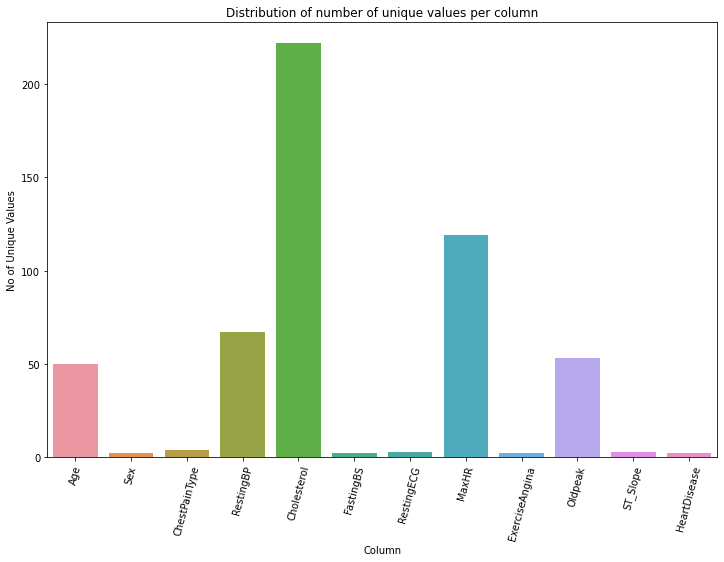

In [8]:
# plot unique values
sns.barplot(data=counts_df, x='Column', y='No of Unique Values')
plt.title("Distribution of number of unique values per column")
plt.xticks(rotation = 75)
plt.show()

In [9]:
# summary statistics of numerical columns
df.describe()

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,HeartDisease
count,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000
mean,53.510893,132.396514,198.799564,0.233115,136.809368,0.887364,0.553377
std,9.432617,18.514154,109.384145,0.423046,25.460334,1.066570,0.497414
min,28.000000,0.000000,0.000000,0.000000,60.000000,-2.600000,0.000000
25%,47.000000,120.000000,173.250000,0.000000,120.000000,0.000000,0.000000
50%,54.000000,130.000000,223.000000,0.000000,138.000000,0.600000,1.000000
75%,60.000000,140.000000,267.000000,0.000000,156.000000,1.500000,1.000000
max,77.000000,200.000000,603.000000,1.000000,202.000000,6.200000,1.000000


In [10]:
# summary statistics of categorical columns
df.describe(include='object')

,Sex,ChestPainType,RestingECG,ExerciseAngina,ST_Slope
count,918,918,918,918,918
unique,2,4,3,2,3
top,M,ASY,Normal,N,Flat
freq,725,496,552,547,460


#### Observations

Based on the overview, there are no missing values in the data. If there were, we would have employed some methods to handle the missing values. For more information on how to treat missing values, check our previous article.

We can also see that there are three data types in our dataset, i.e. integer(int64), floating point numbers (float) and categorical (object). It is also important to note that the data has 918 rows and 12 columns. The target column (variable) is HeartDisease. Furthermore, we have been able to display the number of unique values for each column and noted that Cholesterol has the highest number of unique values. 

Its worth noting that the data values are spread differently. For instance, the minimum age is 28 while the minimum FastingBS is 0. Also, the maximum FastingB is 1 while maximum Cholesterol is 603. The implication of this is that it will hurt our model unless we perform feature scaling. Feature scaling will be explained and implememnted later in the article. Hold on and enjoy the ride.

Last but not least, there are no duplicates in the dataset.

### Step 2 -  Data Exploration and Analysis

In [11]:
# display count of target variable
target_df = pd.DataFrame(df['HeartDisease'].value_counts().reset_index().values, columns=['class','count'])
target_df['% Count'] = target_df['count'] / len(df) * 100
target_df['% Count'] = round(target_df['% Count'], 2)
target_df

,class,count,% Count
0,1,508,55.34
1,0,410,44.66


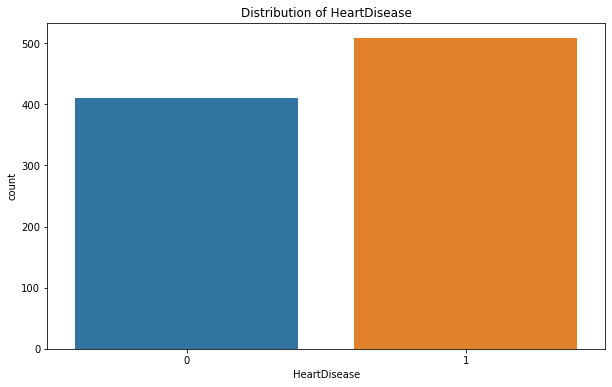

In [12]:
# plot count of target variable
plt.figure(figsize=(10,6))
sns.countplot(df['HeartDisease'])
plt.title("Distribution of HeartDisease")
plt.show()

### Observations

From the above exploration, we note that our target variable (HeartDisease) has more people with the disease than those without the disease. We can also say that the classes in the variable (1: heart disease, 0: Normal) are not so imbalanced as one class is 55% and the other one is 44%. During your data science projects, you may have probably met a case where the target variable is highly imbalanced. That is to say that probabaly one class is 83% while the other class is 17%. In such a scenario there are certain techniques you can use to handle the imbalance. If not handled, this will affect the performance of your model since the model will not have enough data from the minority class to learn and predict it.



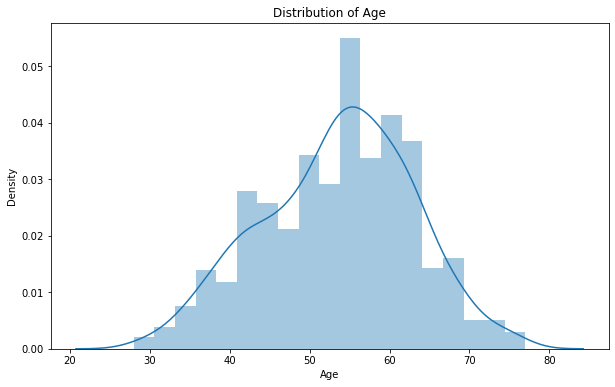

Maximum age of patients:  77
Minimum age of patients:  28


In [13]:
#plot the graph
plt.figure(figsize=(10,6))
sns.distplot(df['Age'])
plt.title("Distribution of Age")
plt.show()

# print max and min age
print("Maximum age of patients: ", df['Age'].max())
print("Minimum age of patients: ", df['Age'].min())

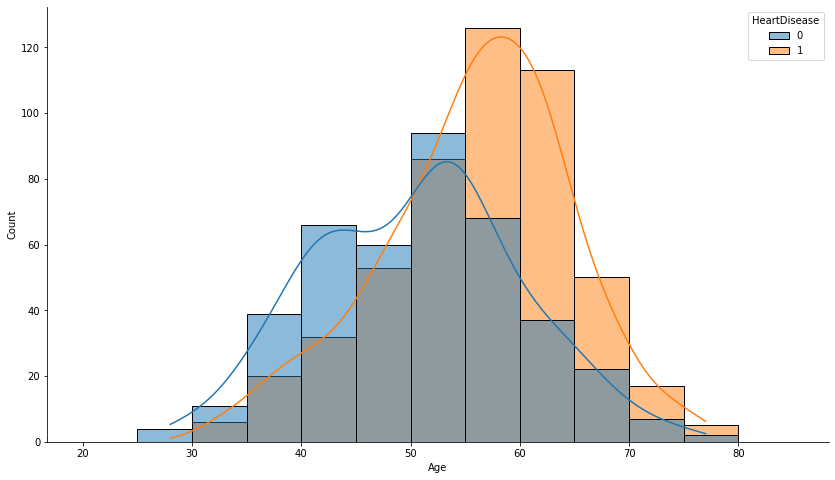

In [14]:
# check which age group has the maximum cases of heart failure
bins = [20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85]
plt.figure(figsize=(14, 8))
sns.histplot(data=df, x="Age", kde=True, hue="HeartDisease", bins=bins);
sns.despine(top=True, right=True)

The distribution of the age skewed to the right with the minimum age of 28 years and maximum age of 77 years. From the second figure, we can see that patients within the age bracket of 55 to 65 have the maximum number of heart failures.

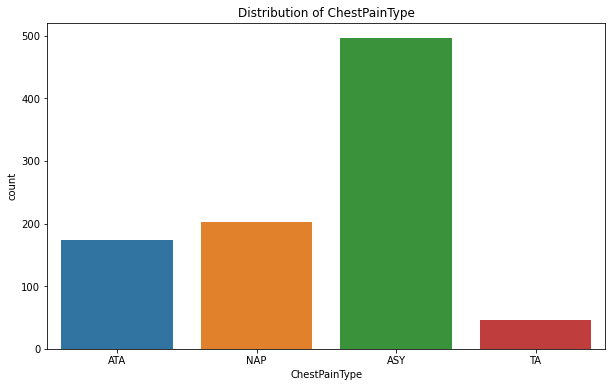

In [15]:
# plot distribution of chestpain type
plt.figure(figsize=(10,6))
sns.countplot(df['ChestPainType'])
plt.title("Distribution of ChestPainType")
plt.show()

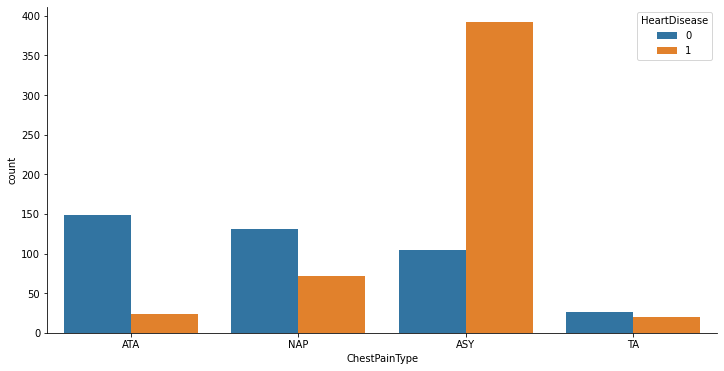

In [16]:
# check chestpaintype highly associated with heart failure
plt.figure(figsize=(12, 6))
sns.countplot(data=df, x='ChestPainType', hue='HeartDisease');
sns.despine(top=True, right=True)

Most of the pateints have ASY type of chest pain. We can also note that the highest number of heart failures are associated with pateints who have ASY type of chest pain. Patients with ATA type of chest pain have the lowest number of heart failures.

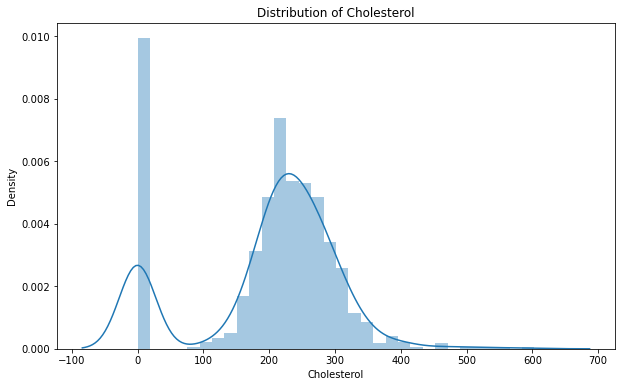

Maximum cholesterol level of patients:  603
Minimum cholesterol level of patients:  0


In [17]:
#plot the graph
plt.figure(figsize=(10,6))
sns.distplot(df['Cholesterol'])
plt.title("Distribution of Cholesterol")
plt.show()

# print max and min cholesterol levels
print("Maximum cholesterol level of patients: ", df['Cholesterol'].max())
print("Minimum cholesterol level of patients: ", df['Cholesterol'].min())

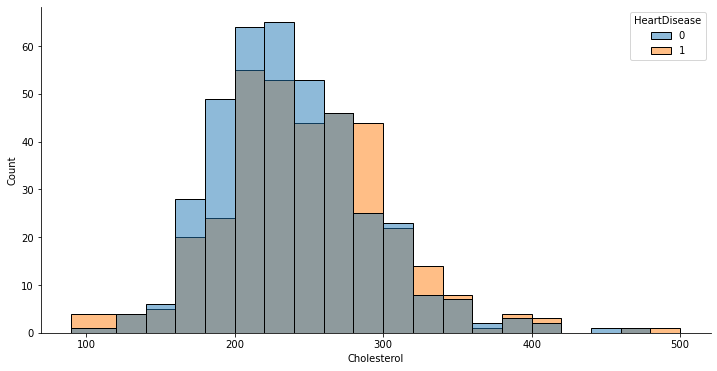

In [18]:
# check the levels of cholesterol with maximum number of heart failure
bins = [90, 120, 140, 160, 180, 200, 220, 240, 260, 280, 300, 320, 340, 360, 380, 400, 420, 440, 460, 480, 500]
plt.figure(figsize=(12, 6))
sns.histplot(data=df, x="Cholesterol", bins=bins, hue="HeartDisease");
sns.despine(top=True, right=True)

From the data, the lowests and highest level of cholesterol in patients is 0 and 603 respectively. Pateints with chelesterol level of between 280 and 300 have the highest incidences of heart failures.

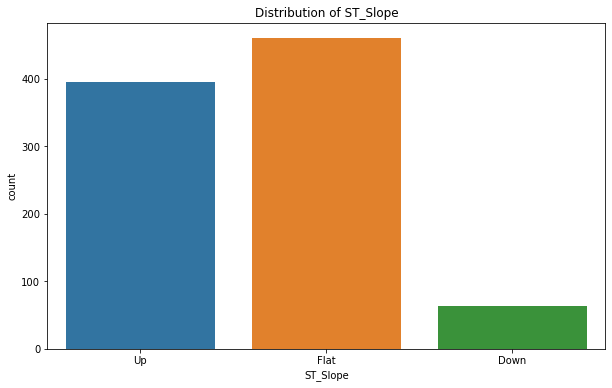

In [19]:
# plot ST Slope
plt.figure(figsize=(10,6))
sns.countplot(df['ST_Slope'])
plt.title("Distribution of ST_Slope")
plt.show()

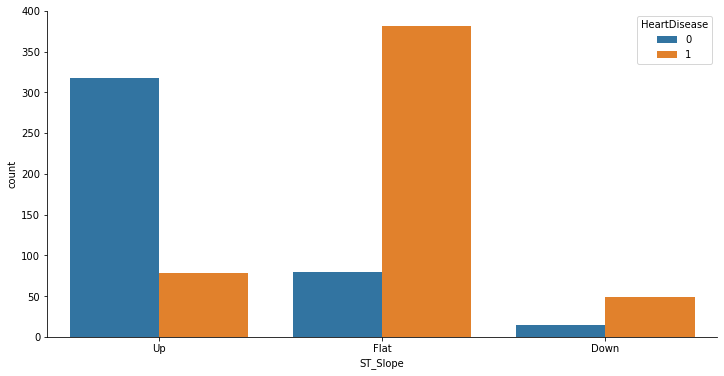

In [20]:
# check the type of ST Slope with highest number of heart failure
plt.figure(figsize=(12, 6))
sns.countplot(data=df, x="ST_Slope", hue="HeartDisease");
sns.despine(top=True, right=True)

From the analysis, heart failure is common in pateints with Flat ST_Slope while pateints with Upsloping peak of excercise ST segment have lesser heart failures. 

### Step 3 - Data Preparation

To prepare our data for the model, we will do three things: 

- create dummy variables
- feature scaling
- splitting the data into training and testing set

In [21]:
# create dummies

cat_cols = ['Sex', 'ChestPainType','RestingECG','ExerciseAngina', 'ST_Slope']

df = pd.get_dummies(df, columns=cat_cols, prefix_sep = ':')

In [22]:
df.head()

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,HeartDisease,Sex:F,Sex:M,ChestPainType:ASY,...,ChestPainType:NAP,ChestPainType:TA,RestingECG:LVH,RestingECG:Normal,RestingECG:ST,ExerciseAngina:N,ExerciseAngina:Y,ST_Slope:Down,ST_Slope:Flat,ST_Slope:Up
0,40,140,289,0,172,0.0,0,0,1,0,...,0,0,0,1,0,1,0,0,0,1
1,49,160,180,0,156,1.0,1,1,0,0,...,1,0,0,1,0,1,0,0,1,0
2,37,130,283,0,98,0.0,0,0,1,0,...,0,0,0,0,1,1,0,0,0,1
3,48,138,214,0,108,1.5,1,1,0,1,...,0,0,0,1,0,0,1,0,1,0
4,54,150,195,0,122,0.0,0,0,1,0,...,1,0,0,1,0,1,0,0,0,1


In [23]:
# splitting the data

X = df.drop('HeartDisease',axis=1)
y = df['HeartDisease']

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state=102)

In [24]:
print("Shape of X_train: ", X_train.shape)
print("Shape of y_train: ", y_train.shape)
print("Shape of X_test: ", X_test.shape)
print("Shape of y_test: ", y_test.shape)

Shape of X_train:  (642, 20)
Shape of y_train:  (642,)
Shape of X_test:  (276, 20)
Shape of y_test:  (276,)


In [25]:
# fit scaler on training data
normalizer = MinMaxScaler().fit(X_train)

# transform training data
X_train_norm = normalizer.transform(X_train)

# transform testing data
X_test_norm = normalizer.transform(X_test)

### Step 4 - Modeling

In [26]:
# building a logistic regression model
classifier = LogisticRegression()
classifier.fit(X_train_norm, y_train)

LogisticRegression()

In [27]:
# predict the testing set
y_pred = classifier.predict(X_test_norm)
y_pred

array([0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1,
       0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0,
       0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1,
       0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1,
       0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0,
       1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1,
       1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0,
       1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1,
       0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1,
       1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1,
       0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1])

#### Model evaluation

In [28]:
accuracy_score(y_test,y_pred)

0.8768115942028986

Our model has accuracy of 88%, which is great since our classes were not so much imbalanced. Let us go ahead and check other metrics.

In [29]:
# plot roc curve
def generate_auc_roc_curve(clf, X_test, y_test):
    y_pred_proba = clf.predict_proba(X_test)[:, 1]
    fpr, tpr, thresholds = roc_curve(y_test,  y_pred_proba)
    auc = roc_auc_score(y_test, y_pred_proba)
    plt.plot(fpr, fpr, linestyle = '--', color = 'r')
    plt.plot(fpr,tpr,label="AUC ROC Curve with Area Under the curve ="+str(auc))
    plt.legend(loc=4)
    plt.show()
    pass

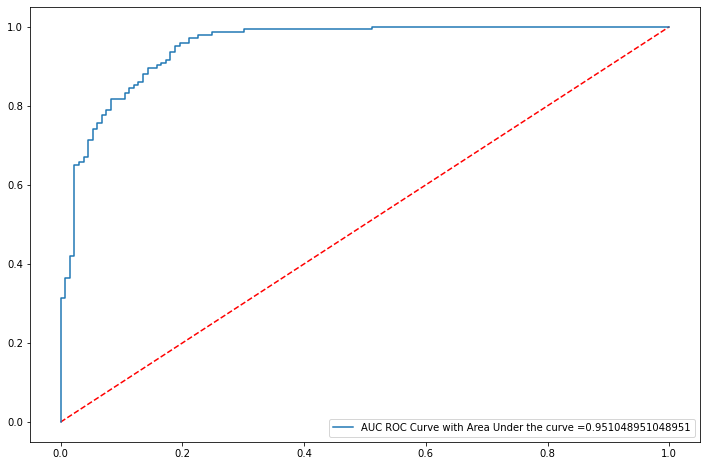

In [30]:
generate_auc_roc_curve(classifier, X_test_norm, y_test)

Our model has AUC Score of 95% which means that it has a great power to separate patients who are susceptible to heart failures from those who are not. This is a model that can be put into production.

In [31]:
# create a confusion matrix 
def conf_matrix(y_test, pred_test):    
    
    # Creating a confusion matrix
    con_mat = confusion_matrix(y_test, pred_test)
    con_mat = pd.DataFrame(con_mat, range(2), range(2))
   
    #Ploting the confusion matrix
    plt.figure(figsize=(10,8))
    sns.set(font_scale=1.5) 
    sns.heatmap(con_mat, annot=True, annot_kws={"size": 16}, fmt='g', cmap='Blues', cbar=False)
    
    # labels, title and ticks
    plt.xlabel('Predicted labels');plt.ylabel('True labels'); 
    pass

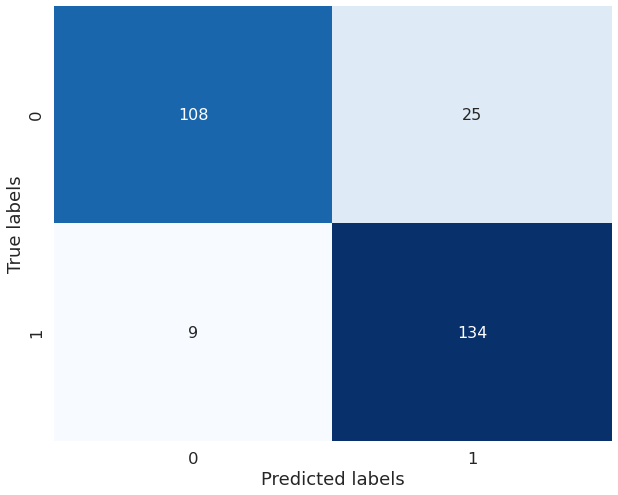

In [32]:
conf_matrix(y_test, y_pred)

From the confusion matrix, we note that the model is good in predicting both classes. There are few false positive and false negatives.

In [33]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.92      0.81      0.86       133
           1       0.84      0.94      0.89       143

    accuracy                           0.88       276
   macro avg       0.88      0.87      0.88       276
weighted avg       0.88      0.88      0.88       276



Precision, Recall and F1-score for both classes are above 80% which points to the predictive power of our  model. These are good scores. A further fine-tuning can be done to improve the model. Please note that in real world scenario it may not be possible to get such good scores for the first time. It takes several iteration of preparing the data, feature engineering and hyperparameter tuning to get best scores. This is beacuse real world data is never as clean as this one.

### Saving the model

In [34]:
with open('model.pkl','wb') as files:
    pickle.dump(classifier, files)